<font size='5'>Empirical Transition Matrix & Auto-Correlation</font>

This notebook demonstrates how sampling from the posterior of the variational inference model works when we construct a transition matrix during the sampling process.

P = \begin{bmatrix}
p_{1,1} & p_{1,2} & p_{1,3} & p_{1,4} \\
p_{2,1} & p_{2,2} & p_{2,3} & p_{2,4} \\
p_{3,1} & p_{3,2} & p_{3,3} & p_{3,4} \\
p_{4,1} & p_{4,2} & p_{4,3} & p_{4,4} \\
\end{bmatrix}

is defined as the probability of transitioning from any given latent state to another, and these transition probabilities are based on the probability across the whole dataset generated in an iterative fashion.

In [38]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

Testing a small universe of the 10Y Treasury, a Commodity ETF, and Tech ETF. The goal will be time series clustering using variational inference. There are periods of time (regimes) where certain assets outperform the others and their precise relationship is captured by the latent state. 

Set num_components to a very high number so the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [39]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 9

Create the subset of assets.

In [40]:
m6 = pd.read_csv('.././data/assets_m6.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

Formatting the training data; use of the rolling mean log price increases serial correlation in the post-processed data. 

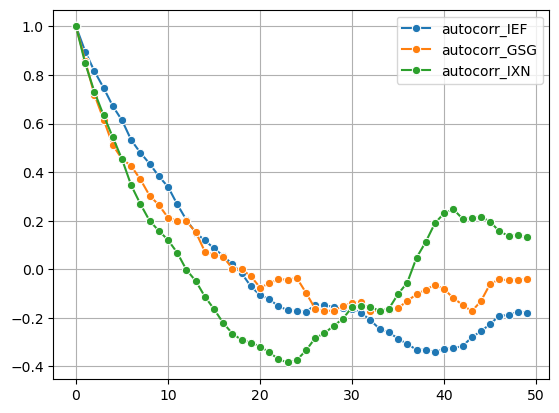

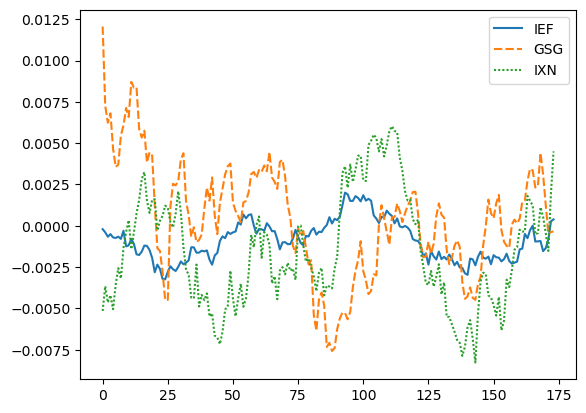

In [41]:
m6_subset = m6_assets.copy().apply(np.log).rolling(25).mean().apply(np.diff)
m6_subset = m6_subset.dropna().reset_index().drop(columns='index')

autocorr_df = pd.DataFrame()
autocorr_df['decay_IEF'] = m6_subset['IEF']
autocorr_df['decay_GSG'] = m6_subset['GSG']
autocorr_df['decay_IXN'] = m6_subset['IXN']
decay_func = lambda S, _range: [S.apply(abs).autocorr(lag=Lag) for Lag in _range]

sns.lineplot(data=decay_func(autocorr_df['decay_IEF'], range(0, 50)), label='autocorr_IEF', marker='o')
sns.lineplot(data=decay_func(autocorr_df['decay_GSG'], range(0, 50)), label='autocorr_GSG', marker='o')
sns.lineplot(data=decay_func(autocorr_df['decay_IXN'], range(0, 50)), label='autocorr_IXN', marker='o')
plt.grid(True)
plt.show()

sns.lineplot(data=m6_subset)
plt.show()

Instantiate a non-parametric clustering model using the dirichlet process. Then, sample len(m6_subset) points from the variational model. This sampling should respect the empirical transition matrix of the data. After re-sampling, the call to the decay_func() shows that auto-correlation drops off sharply as compared to the original data. 

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2]
[-0.00089483  0.00041791 -0.00149478 -0.0008948   0.00041787 -0.00149474
  0.00057644 -0.00116222  0.0033844  -0.00122614  0.00077195 -0.00260769
 -0.0008896   0.00041087 -0.00148885 -0.0008896   0.00041087 -0.00148884
 -0.0008896   0.00041087 -0.00148884 -0.0008896   0.00041087 -0.00148884
 -0.0008896   0.00041087 -0.00148884]


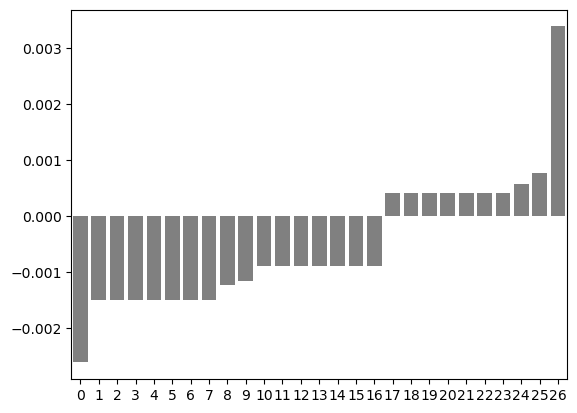

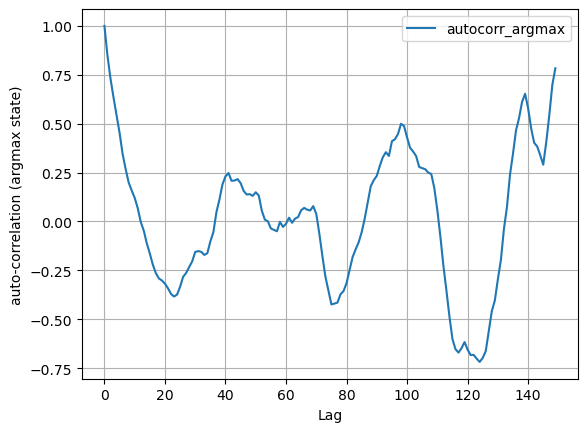

Note: you may need to restart the kernel to use updated packages.


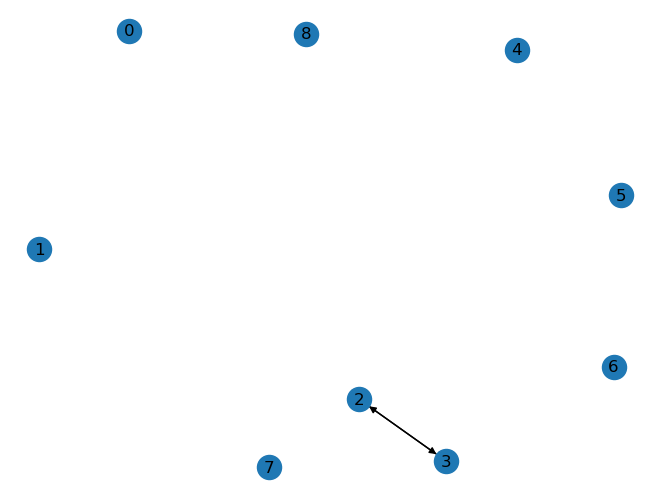

In [51]:
# Fit Model
dpgmm_model = mix.BayesianGaussianMixture(
    n_components=num_components, 
    weight_concentration_prior_type='dirichlet_process',
    n_init=10,
    max_iter=1000)
states = dpgmm_model.fit_predict(m6_subset)
print(states)

# EMPIRICAL TRANSITION MATRIX 
num_states = num_components

# Initialize the transition matrix with zeros
transition_matrix = np.zeros((num_states, num_states))

# Loop through the array of states and update the transition matrix
for i in range(len(states)):
    current_state = states[i]
    previous_state = states[i-1]
    transition_matrix[previous_state, current_state] += 1

# Normalize the transition matrix and zero out connections to un-used clusters
transition_matrix = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)
transition_matrix[np.isnan(transition_matrix)] = 0.

# Mixture Means
m=dpgmm_model.means_.flatten()
print(m)
sns.barplot(x=list(range(len(m))), y=sorted(m), color='grey')
plt.show()

# Include state counts
state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

# View Auto-Correlation of most common state 
statesdf=pd.DataFrame()
statesdf['bayes_filter']=m6_subset['IXN']#[ 1 if states[M] == np.argmax(state_counts) else 0 for M in range(0, len(states)) ]
statesdf=statesdf.dropna()

sns.lineplot(data=decay_func(statesdf['bayes_filter'], range(0, 150)), label='autocorr_argmax')
plt.xlabel('Lag')
plt.ylabel('auto-correlation (argmax state)')
plt.grid(True)
plt.show()

# View as graph
%pip install networkx 
import networkx as nx
import matplotlib.pyplot as plt 

G = nx.DiGraph(transition_matrix)
nx.draw(G, with_labels=True)
plt.show()

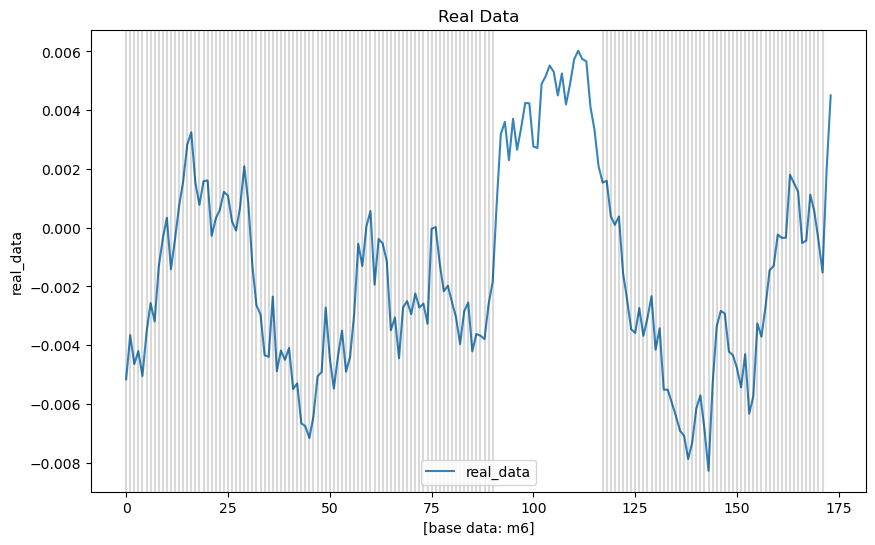

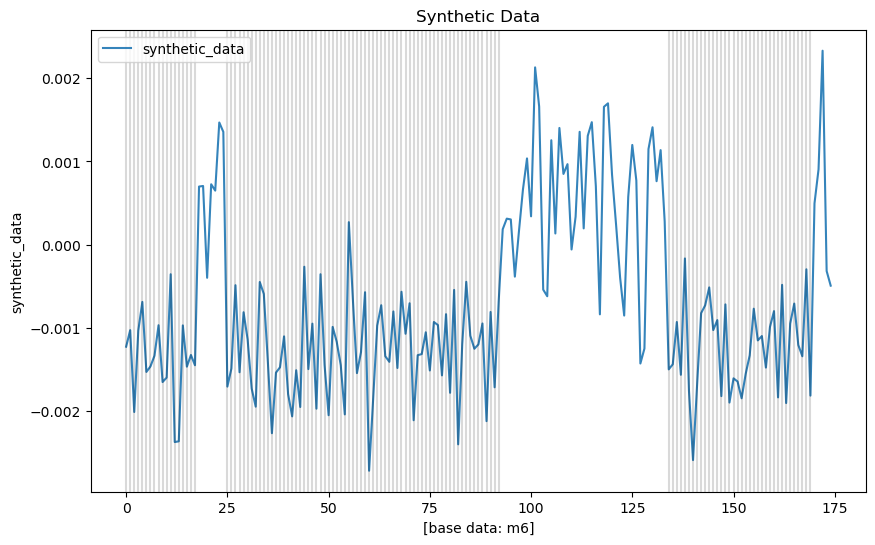

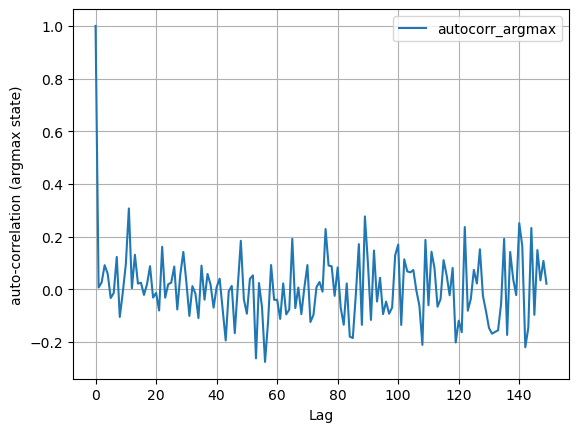

In [54]:
# Samples
y = [] 
sample = []

# Sample one at a time using transition matrix, starting with same initial conditions 
current_state = states[0]
sample.append(np.random.normal(loc=dpgmm_model.means_[current_state][0], scale=dpgmm_model.covariances_[current_state][0])[0])
y.append(current_state)
    
# Sample the posterior distribution states based on transition matrix 
for i in range(len(m6_subset)):
    current_state = np.random.choice(num_states, p=transition_matrix[current_state])
    current_mean = dpgmm_model.means_[current_state][0]
    current_var = dpgmm_model.covariances_[current_state][0]
    s = np.random.normal(loc=current_mean, scale=np.sqrt(current_var))
    sample.append(s[2]) 
    y.append(current_state)

# Count states 
y_counts = np.zeros(num_components)
for M in y:
  y_counts[M] += 1 

# View real data 
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.lineplot(data=m6_subset['IXN'], alpha=0.9, ax=ax)
plt.legend(labels=['real_data'])
plt.title('Real Data')
plt.ylabel('real_data')
plt.xlabel('[base data: m6]')

for M in range(len(states)): 
  if states[M] == np.argmax(state_counts):
    ax.axvline(M, color='black', alpha=0.15)
plt.show()

# View synthetic data 
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.lineplot(data=sample, alpha=0.9, ax=ax)
plt.legend(labels=['synthetic_data'])
plt.title('Synthetic Data')
plt.ylabel('synthetic_data')
plt.xlabel('[base data: m6]')

for M in range(len(y)): 
  if y[M] == np.argmax(y_counts):
    ax.axvline(M, color='black', alpha=0.15)
plt.show()

# View Auto-Correlation of most common state 
ydf=pd.DataFrame()
ydf['bayes_filter']=sample#[ 1 if y[M] == np.argmax(y_counts) else 0 for M in range(0, len(y)) ]
ydf=ydf.dropna()

sns.lineplot(data=decay_func(ydf['bayes_filter'], range(0, 150)), label='autocorr_argmax')
plt.xlabel('Lag')
plt.ylabel('auto-correlation (argmax state)')
plt.grid(True)
plt.show()